# Trabajo práctico nro 1 de AA2.

**Alumno: MARCOS DARIO GALLO**


**Profesora: ANA LAURA DIEDRICH**

**Materia: APRENDISAJE AUTOMATICO 2**








# Clasificador MLP binario en MNIST (0 vs 8) - Underfitting, Buen rendimiento y Overfitting

## 1- Usar pytorch para crear una clase que herede de dataset para crear un dataset propio.

El dataset está basado en el original de MNIST. En este dataset sólo se guardan dos de las 10 clases del dataset original


Lo que se hará es:

Filtrar los dígitos 0 y 8 del MNIST.

Remapear etiquetas: 0 → 0, 8 → 1.

Dividir el dataset en entrenamiento, validación y prueba.

Preparar los datos para ser usados en una red neuronal binaria.

In [1]:
# Se importan las librerías necesarias
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, f1_score

# Dataset personalizado para clases 0 y 8 remapeadas a 0 y 1
class MNISTSubset(Dataset):  # define una subclase de Dataset, que personaliza el uso de MNIST.
    def __init__(self, root='./data', train=True, download=True, transform=None, target_classes=[0, 8]):
        self.mnist_dataset = datasets.MNIST(root=root, train=train, download=download, transform=transform) #Se carga el dataset original MNIST, ya filtrado con los parametros.
        self.target_classes = target_classes #Guarda las clases objetivo, es decir [0, 8].
        self.indices = [i for i, target in enumerate(self.mnist_dataset.targets) if target in self.target_classes] #Crea una lista de índices de los ejemplos cuya etiqueta (target) es 0 u 8. self.mnist_dataset.targets contiene todas las etiquetas.
        self.targets = [self.target_classes.index(self.mnist_dataset.targets[i].item()) for i in self.indices] #Remapea las etiquetas originales:
                                                                                                               # target_classes.index(...) convierte el dígito real a la clase binaria (0 → 0, 8 → 1).
                                                                                                               # self.mnist_dataset.targets[i].item() obtiene el valor entero del tensor.

        self.targets = torch.tensor(self.targets) #Convierte la lista de etiquetas a un tensor de PyTorch, para compatibilidad con modelos y entrenamiento.

    def __len__(self):
        return len(self.indices) #Devuelve la cantidad de ejemplos filtrados, o sea, cuántas imágenes tienen etiqueta 0 u 8.

    def __getitem__(self, idx): #Este método permite acceder a los ejemplos como si fueran una lista. Devuelve:
        image, _ = self.mnist_dataset[self.indices[idx]]   # image: la imagen de índice idx, ya transformada
        target = self.targets[idx]                         # target: la etiqueta remapeada (0 o 1) correspondiente.
        return image, target                              #Recupera la imagen y su etiqueta (remapeada como 0 o 1).


transform = transforms.Compose([transforms.ToTensor()]) #Convierte las imágenes de PIL a tensores (FloatTensor) y normaliza a [0, 1].

mnist_subset = MNISTSubset(train=True, transform=transform, target_classes=[0, 8]) #Se crea una instancia del dataset personalizado solo con dígitos 0 y 8.


Ahora se define una red neuronal multicapa personalizada (MLP) en PyTorch, diseñada para clasificación binaria, que va a ser en este caso diferenciar entre los dígitos 0 y 8 de MNIST.

Esta clase define un MLP totalmente configurable, con:

Número de capas ocultas y unidades personalizables.

Activación configurable (ReLU, Tanh, etc.).

Salida final con función sigmoide para clasificación binaria.

In [2]:

# Modelo flexible configurable
class CustomMLP(nn.Module): #Se define una clase que hereda de nn.Module, la clase base para todos los modelos en PyTorch.
    def __init__(self, input_size=784, hidden_sizes=[128, 64], activation_fn=nn.ReLU):#Cada imagen de MNIST tiene 28x28 = 784 píxeles (plana).Dos capas ocultas con 128 y 64 neuronas y  por defecto no se usa Dropout.
        super(CustomMLP, self).__init__() # Llama al constructor de nn.Module. Es obligatorio para registrar los parámetros del modelo correctamente.
        layers = []  # layers acumulará las capas del modelo.
        in_features = input_size #in_features comienza con 784, es decir, el número de entradas. Se actualiza a cada paso.

        for h in hidden_sizes: #Se recorre la lista hidden_sizes
            layers.append(nn.Linear(in_features, h)) #Se agrega una capa lineal completamente conectada
            layers.append(activation_fn()) #Se añade la función de activación.
            in_features = h #Se actualiza in_features para la siguiente capa.

        layers.append(nn.Linear(in_features, 1)) #Se agrega la última capa lineal, con 1 sola neurona de salida. No se le aplica activación aquí, porque se usará sigmoid luego en el forward.
        self.model = nn.Sequential(*layers) #nn.Sequential permite encadenar las capas.

    def forward(self, x):
        x = x.view(x.size(0), -1) #aplana cada imagen a un vector de tamaño [batch_size, 784].
        return torch.sigmoid(self.model(x)) #torch.sigmoid(...) convierte la salida en una probabilidad entre 0 y 1, adecuada para clasificación binaria.
                                            #self.model(x) aplica todas las capas definidas en __init__.


Ahora se definirá una función que entrena un modelo MLP personalizado (CustomMLP).

- Primero crea el modelo con hiperparámetros personalizados:

Tamaños de capas ocultas (hidden_layers).

Función de activación.

Optimizador (SGD, Adam o RMSprop).

Tasa de aprendizaje.

- Configura la pérdida como Binary Cross Entropy (BCELoss), adecuada para salidas de tipo probabilidad (sigmoid).

- Se fijan semillas para asegurar la reproducibilidad de la división de datos y del entrenamiento.

- Divide el subconjunto de MNIST (mnist_subset) en entrenamiento (80%) y validación (20%), y prepara DataLoaders para ambos, con minibatches de tamaño 64. También se prepara un DataLoader para el conjunto de prueba.

- Entrena el modelo durante varias épocas:

Ejecuta forward, backward y actualiza los pesos con el optimizador seleccionado.

Calcula y guarda la pérdida promedio de entrenamiento por época.

- Cambia el modelo a modo evaluación para validar el desempeño (model.eval()).

Evalúa el modelo al final de cada época:

Calcula la pérdida y precisión sobre el conjunto de validación.

Guarda todas las predicciones y etiquetas verdaderas para un análisis más detallado posterior.

- Muestra métricas por consola por cada época:

Pérdida de entrenamiento

Pérdida de validación

Precisión de validación

- Devuelve:

El modelo entrenado

Listas de pérdidas (train/val) y precisión (val)

Listas de todas las predicciones y etiquetas verdaderas (all_preds, all_labels).




In [3]:

# Función de entrenamiento general
def train_custom_model(hidden_layers, lr=0.001, epochs=10, optimizer_name='Adam', activation_fn=nn.ReLU):
    model = CustomMLP(hidden_sizes=hidden_layers, activation_fn=activation_fn) #Se crea el modelo CustomMLP con los parámetros indicados.
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #Se mueve a la GPU si está disponible.
    model.to(device)

    criterion = nn.BCELoss() #Se usa la Binary Cross Entropy como función de pérdida, adecuada para clasificación binaria.

#Se elige entre diferentes optimizadores según el nombre pasado.
    if optimizer_name == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=lr)
    elif optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=lr)
    else:
        raise ValueError("Optimizador no reconocido")

    #Se divide el dataset en: 80% para entrenamiento. 20% para validación
    train_size = int(0.8 * len(mnist_subset))
    val_size = len(mnist_subset) - train_size

    # Para hacer reproducible la ejecución del código
    torch.manual_seed(42)
    generator = torch.Generator().manual_seed(42)
    train_dataset, val_dataset = random_split(mnist_subset, [train_size, val_size], generator=generator)


    # Creacion de los dataloaders
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True) #Los DataLoader permiten iterar sobre los datos en minibatches de tamaño 64.
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    test_dataset = MNISTSubset(train=False, transform=transform, target_classes=[0, 8]) #También se convierte en formato binario con target_classes=[0, 8].
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False) #El de entrenamiento se baraja en cada época (shuffle=True) para evitar sesgos.

#Se guardarán las métricas de entrenamiento y validación por época:
    train_losses, val_losses, val_accuracies = [], [], []

#Comienza el bucle de entrenamiento.
    for epoch in range(epochs):
# Modo entrenamiento
        model.train()
        running_loss = 0
        for images, labels in train_loader:               #Se recorren los batches del train_loader.
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1) #unsqueeze(1) convierte etiquetas de tamaño [batch] a [batch, 1] para que coincidan con la salida del modelo.
            outputs = model(images)
            loss = criterion(outputs, labels)  #Se calcula la pérdida, se hace backpropagation y se actualizan los pesos.

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item() #running_loss acumula la pérdida total del epoch.

        train_losses.append(running_loss / len(train_loader)) #Se guarda la pérdida promedio de la época.

#Modo evaluación (validación)
        model.eval()
        val_loss = 0
        correct, total = 0, 0
        all_preds = []  # Lista para almacenar todas las predicciones
        all_labels = []  # Lista para almacenar todas las etiquetas verdaderas
        with torch.no_grad():  #Se desactiva el cálculo de gradientes
            for images, labels in val_loader: #Se calcula la pérdida y precisión sobre los datos de validación.
                images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
                outputs = model(images)
                val_loss += criterion(outputs, labels).item()

                preds = (outputs > 0.5).float()  #Las predicciones se redondean: si output > 0.5, se considera clase 1.
                all_preds.extend(preds.cpu().numpy())  # Guardamos las predicciones
                all_labels.extend(labels.cpu().numpy())  # Guardamos las etiquetas reales

                correct += (preds == labels).sum().item()
                total += labels.size(0)

#Se registran la pérdida y precisión media del epoch.
        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(correct / total)
#Imprime métricas clave por cada época.
        print(f"Epoch {epoch+1}: Train Loss={train_losses[-1]:.4f} | Val Loss={val_losses[-1]:.4f} | Val Acc={val_accuracies[-1]*100:.2f}%")

#Devuelve: El modelo entrenado y ñas listas de pérdida y precisión por época (útiles para graficar o diagnosticar underfitting/overfitting).
    return model, train_losses, val_losses, val_accuracies, all_preds, all_labels


Defino una función plot_results que genera dos gráficos lado a lado para visualizar cómo evoluciona el rendimiento del modelo durante el entrenamiento.

In [4]:

def plot_results(train_losses, val_losses, val_accuracies, ruta_imagen, title):
    epochs = range(1, len(train_losses)+1) #genera una secuencia de números desde 1 hasta el número de épocas. Sirve como eje x para los gráficos.
    plt.figure(figsize=(14,5))
    plt.subplot(1, 2, 1)   #subplot(1, 2, 1) define el primer gráfico de un total de 2 en una fila
    #Se grafican las curvas de pérdida de entrenamiento y validación.
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Val Loss')
    #Se agregan etiquetas, título y leyenda.
    plt.title(f"{title} - Pérdida")
    plt.xlabel("Épocas")
    plt.ylabel("Pérdida")
    plt.legend()

    plt.subplot(1, 2, 2) #subplot(1, 2, 2) define el segundo gráfico.
    #Se grafica la precisión del conjunto de validación.
    plt.plot(epochs, val_accuracies, label='Val Accuracy')
    plt.title(f"{title} - Precisión")
    plt.xlabel("Épocas")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.savefig(ruta_imagen)
    plt.show()


## Entrenamientos configurables

Se intenta con esta configuración llegar a entrenar un modelo con **Underfitting**

Para lo cual se colocan los parámetros siguientes:

- hidden_layers=[4]	Muy pequeña	Casi sin capacidad para modelar relaciones complejas

- lr=0.0001	(Aprendizaje muy lento)
- epochs=5	(Pocas épocas	No da tiempo a aprender patrones significativos)
- optimizer='SGD'	(Más lento que Adam en convergencia inicial)
- activation=nn.Tanh	(Menos agresiva que ReLU)

Epoch 1: Train Loss=0.7246 | Val Loss=0.7155 | Val Acc=50.19%
Epoch 2: Train Loss=0.7095 | Val Loss=0.7019 | Val Acc=50.19%
Epoch 3: Train Loss=0.6961 | Val Loss=0.6891 | Val Acc=50.19%
Epoch 4: Train Loss=0.6831 | Val Loss=0.6770 | Val Acc=50.19%
Epoch 5: Train Loss=0.6714 | Val Loss=0.6655 | Val Acc=50.28%


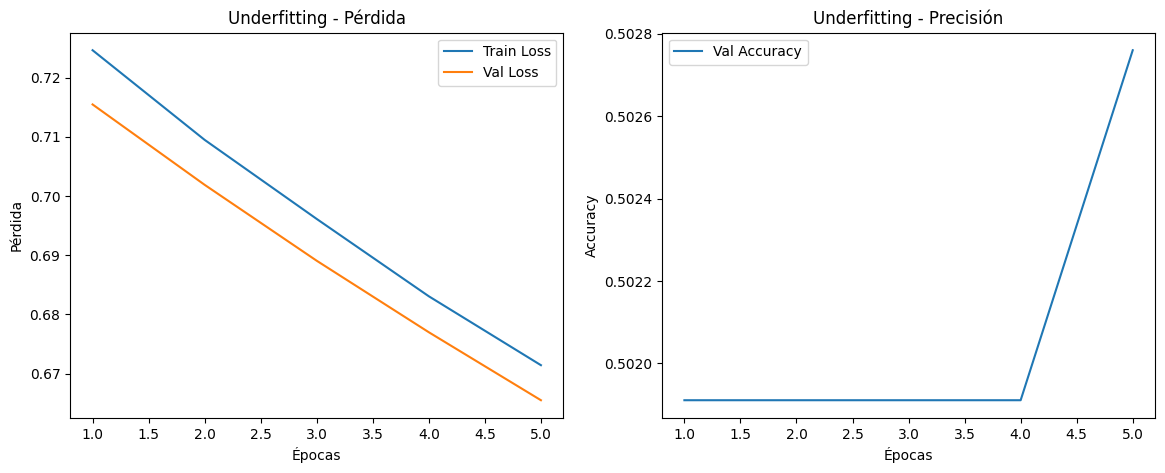

Modelo usado en UNDERFITTING:
CustomMLP(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=4, bias=True)
    (1): Tanh()
    (2): Linear(in_features=4, out_features=1, bias=True)
  )
)
Reporte de clasificación final:
              precision    recall  f1-score   support

         0.0       0.50      1.00      0.67      1182
         1.0       1.00      0.00      0.00      1173

    accuracy                           0.50      2355
   macro avg       0.75      0.50      0.34      2355
weighted avg       0.75      0.50      0.34      2355



In [9]:
# Underfitting
model_under, losses_u, val_losses_u, accs_u, all_preds, all_labels = train_custom_model(
    hidden_layers=[4],
    lr=0.0001,
    epochs=5,
    optimizer_name='SGD',
    activation_fn=nn.Tanh
)

ruta_imagen = "images/underfiting_loss_accuracy_plot.png"
plot_results(losses_u, val_losses_u, accs_u, ruta_imagen, "Underfitting")


print("Modelo usado en UNDERFITTING:")
print(model_under)
print("Reporte de clasificación final:")
print(classification_report(all_labels, all_preds))  # Imprime reporte completo


### 📌 Conclusiones del Experimento - Underfitting

El análisis de los resultados obtenidos muestra que el modelo entrenado presenta un claro problema de underfitting, debido a su arquitectura muy simple.

Esto se observa tanto en las métricas como en los gráficos de pérdida y precisión. La pérdida de entrenamiento y validación disminuyen de manera progresiva y pareja a lo largo de las épocas, pero sus valores se mantienen elevados (alrededor de 0.63), indicando que el modelo no logra aprender representaciones suficientemente buenas. La precisión de validación aumenta de forma continua, pero alcanza apenas un 74,78% al final de las cinco épocas, un valor bajo considerando que la tarea es una clasificación binaria (dígitos 0 y 8 del MNIST).

El reporte de clasificación final respalda esta conclusión. La clase 0 (dígito 0) es detectada con un recall alto (92%), pero su precision es relativamente baja (69%), indicando que el modelo predice muchos ceros de forma incorrecta. Por otro lado, para la clase 1 (dígito 8), la precision es buena (88%) pero el recall es bajo (57%), lo que significa que muchos ochos no son correctamente detectados. La exactitud general del modelo es de 75%, y el macro F1-score alcanza 0.75, valores que son consistentes con un modelo que no logra capturar adecuadamente los patrones de las imágenes.







Epoch 1: Train Loss=0.6272 | Val Loss=0.5355 | Val Acc=87.13%
Epoch 2: Train Loss=0.4335 | Val Loss=0.3423 | Val Acc=96.73%
Epoch 3: Train Loss=0.2657 | Val Loss=0.2104 | Val Acc=97.15%
Epoch 4: Train Loss=0.1679 | Val Loss=0.1403 | Val Acc=97.58%
Epoch 5: Train Loss=0.1161 | Val Loss=0.1030 | Val Acc=98.05%
Epoch 6: Train Loss=0.0885 | Val Loss=0.0810 | Val Acc=98.17%
Epoch 7: Train Loss=0.0716 | Val Loss=0.0671 | Val Acc=98.34%
Epoch 8: Train Loss=0.0605 | Val Loss=0.0569 | Val Acc=98.56%
Epoch 9: Train Loss=0.0529 | Val Loss=0.0501 | Val Acc=98.73%
Epoch 10: Train Loss=0.0477 | Val Loss=0.0447 | Val Acc=98.81%


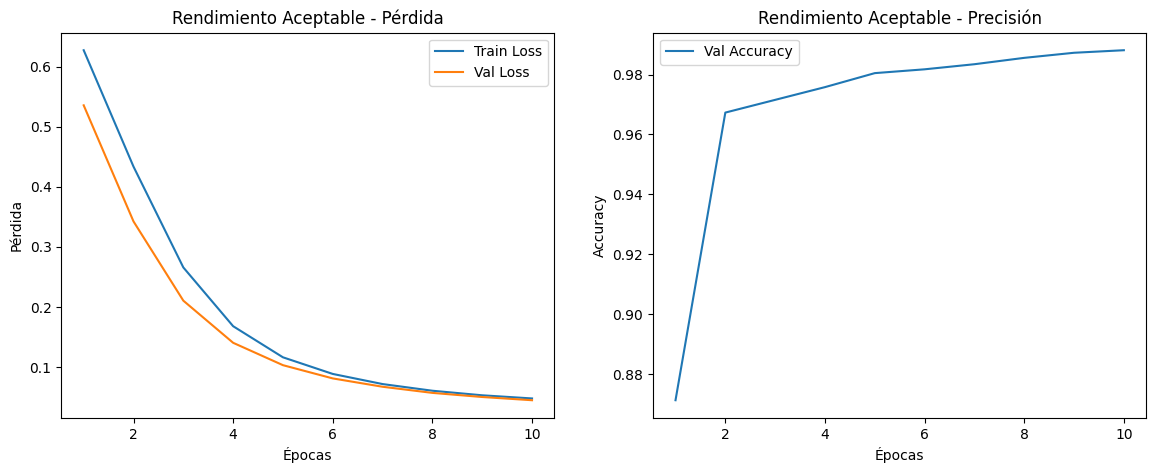

Modelo usado en BUEN RENDIMIENTO:
CustomMLP(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=1, bias=True)
  )
)
Reporte de clasificación final:
              precision    recall  f1-score   support

         0.0       0.99      0.98      0.99      1182
         1.0       0.98      0.99      0.99      1173

    accuracy                           0.99      2355
   macro avg       0.99      0.99      0.99      2355
weighted avg       0.99      0.99      0.99      2355



In [8]:
# Rendimiento aceptable
model_ok, losses_ok, val_losses_ok, accs_ok, all_preds, all_labels = train_custom_model(
    hidden_layers=[16, 8],
    lr=0.0001,
    epochs=10,
    optimizer_name='Adam',
    activation_fn=nn.ReLU
)

ruta_imagen = "images/aceptable_loss_accuracy_plot.png"
plot_results(losses_ok, val_losses_ok, accs_ok, ruta_imagen, "Rendimiento Aceptable")

print("Modelo usado en BUEN RENDIMIENTO:")
print(model_ok)
print("Reporte de clasificación final:")
print(classification_report(all_labels, all_preds))  # Imprime reporte completo

### ✅ Conclusiones del Experimento - Rendimiento Aceptable

La arquitectura empleada en este caso es más compleja y potente que en el escenario anterior de underfitting: consta de dos capas ocultas de 16 y 8 neuronas respectivamente, ambas utilizando la función de activación ReLU, que permite un entrenamiento más eficiente y evita los problemas de saturación de gradientes.

El modelo evaluado en esta instancia presenta un rendimiento aceptable y equilibrado, tanto en las métricas como en los gráficos de pérdida y precisión. La evolución de la pérdida muestra una disminución rápida y consistente a lo largo de las épocas, manteniéndose muy cercana entre el conjunto de entrenamiento y el de validación, lo cual indica una buena capacidad de generalización y ausencia de overfitting. La precisión de validación alcanza valores elevados desde las primeras épocas, estabilizándose cerca del 98,81% al final del entrenamiento, lo que refleja que el modelo aprendió correctamente los patrones relevantes.

El reporte de clasificación confirma este resultado del entrenamiento: se obtuvieron valores de precisión, recall y F1-score iguales o superiores al 98% para ambas clases (dígitos 0 y 8). La exactitud global es del 99%, y tanto el promedio macro como el weighted promedio de F1-score alcanzan también el 99%, indicando que el modelo no sólo clasifica bien en promedio, sino que lo hace de forma balanceada entre las clases.


Epoch 1: Train Loss=0.6920 | Val Loss=0.6844 | Val Acc=50.19%
Epoch 2: Train Loss=0.6623 | Val Loss=0.6247 | Val Acc=65.22%
Epoch 3: Train Loss=0.5221 | Val Loss=0.3891 | Val Acc=97.20%
Epoch 4: Train Loss=0.2583 | Val Loss=0.1657 | Val Acc=97.49%
Epoch 5: Train Loss=0.1173 | Val Loss=0.0909 | Val Acc=97.96%
Epoch 6: Train Loss=0.0733 | Val Loss=0.0634 | Val Acc=98.34%
Epoch 7: Train Loss=0.0558 | Val Loss=0.0504 | Val Acc=98.56%
Epoch 8: Train Loss=0.0468 | Val Loss=0.0422 | Val Acc=98.77%
Epoch 9: Train Loss=0.0413 | Val Loss=0.0375 | Val Acc=98.81%
Epoch 10: Train Loss=0.0378 | Val Loss=0.0335 | Val Acc=99.02%
Epoch 11: Train Loss=0.0354 | Val Loss=0.0311 | Val Acc=99.02%
Epoch 12: Train Loss=0.0332 | Val Loss=0.0286 | Val Acc=99.15%
Epoch 13: Train Loss=0.0319 | Val Loss=0.0268 | Val Acc=99.11%
Epoch 14: Train Loss=0.0307 | Val Loss=0.0254 | Val Acc=99.32%
Epoch 15: Train Loss=0.0297 | Val Loss=0.0244 | Val Acc=99.32%
Epoch 16: Train Loss=0.0326 | Val Loss=0.0235 | Val Acc=99.32%
E

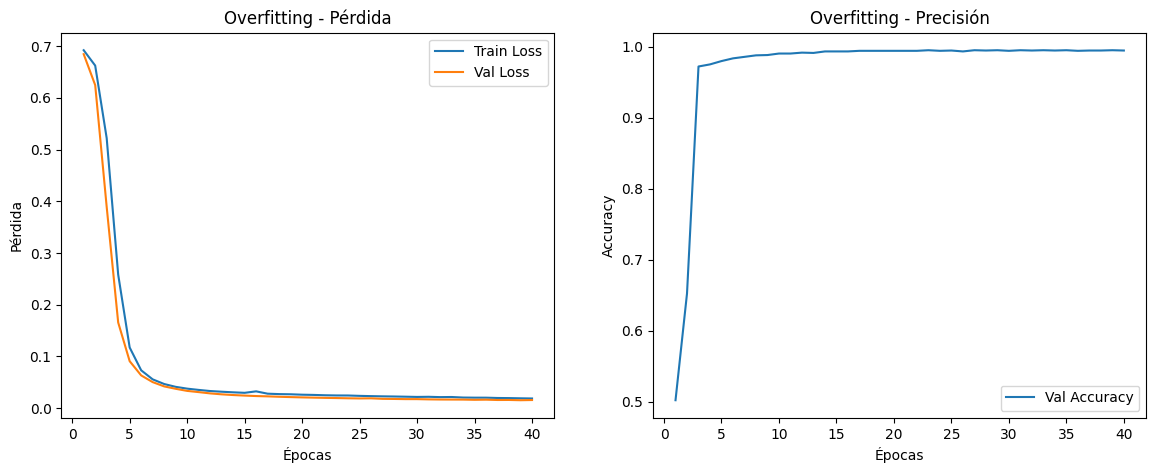

Modelo usado en OVERFITTING:
CustomMLP(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Linear(in_features=64, out_features=32, bias=True)
    (9): ReLU()
    (10): Linear(in_features=32, out_features=1, bias=True)
  )
)
Reporte de clasificación final:
              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99      1182
         1.0       0.99      1.00      0.99      1173

    accuracy                           0.99      2355
   macro avg       0.99      0.99      0.99      2355
weighted avg       0.99      0.99      0.99      2355



In [10]:
# Overfitting
model_over, losses_over, val_losses_over, accs_over, all_preds, all_labels = train_custom_model(
    hidden_layers=[512, 256, 128, 64, 32],
    lr=0.00001,
    epochs=40,
    optimizer_name='Adam',
    activation_fn=nn.ReLU
)

ruta_imagen = "images/overfiting_loss_accuracy_plot.png"
plot_results(losses_over, val_losses_over, accs_over, ruta_imagen, "Overfitting")


print("Modelo usado en OVERFITTING:")
print(model_over)
print("Reporte de clasificación final:")
print(classification_report(all_labels, all_preds))  # Imprime reporte completo


### ⚠️ Conclusiones del Experimento - Overfitting


La arquitectura utilizada para este experimento es considerablemente más profunda y pesada que en los casos anteriores. Se compone de múltiples capas densas (ocho capas lineales) con un gran número de neuronas, comenzando con 512 y descendiendo progresivamente hasta 32. Todas las capas intermedias utilizan la función de activación ReLU. Esto hace que el modelo sea capaz de memorizar los datos de entrenamiento con mucha facilidad, pero a costa de correr el riesgo de no generalizar tan bien en datos nuevos.

Lo que se observa es un caso de overfitting. A nivel de pérdidas, tanto el entrenamiento como la validación muestran una reducción muy rápida en las primeras épocas, alcanzando valores casi nulos, pero la curva de validación, aunque muy próxima, comienza a mostrar leves fluctuaciones, lo que puede anticipar un sobreajuste si el entrenamiento continuara. La precisión de validación es altísima, superando el 99,4%, y se mantiene estable, aunque su crecimiento inicial es extremadamente rápido, lo que demuestra que el modelo es demasiado complejo para el problema planteado.

El reporte de clasificación refleja métricas excelentes, con valores de precisión, recall y F1-score iguales o mayores al 99% para ambas clases. El accuracy global es del 99%, con promedios macro y ponderados igualmente cercanos al 99%. Estos valores, sin embargo, deben ser interpretados con precaución en un contexto de overfitting, ya que en una validación más exigente o ante nuevos datos no vistos, el rendimiento real podría deteriorarse.

El modelo alcanza resultados numéricos sobresalientes, pero su complejidad es excesiva para el problema abordado. La arquitectura no es eficiente y representa un gasto innecesario de recursos computacionales, además de implicar riesgos de generalización si se utilizara en producción.


# Referencias:

- Teoría suministrada por la materia:
 - https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
 -https://pytorch.org/tutorials/beginner/nn_tutorial.html

- Prompts Chat GPT:
 - Prompt: "como puedo hacer reproducible el resultado del split del dataset para que luego, al variar los parámetros del entrenamiento del modelo, obtener resultados comparables"
 - Prompt: "En base al codigo que te paso, genera una función que permita la creación de un modelo customizable en parametros como: n° épocas, cantidad de capas ocultas y n° de neuronas, tipo de optimizador, learning rate y tipo de función de activación."
 - Prompt: "Explica con teoría y ejemplos como afectan cada uno de los parámetros ( n° de neuronas y épocas de entrenamiento, optimizador, función de activación, learning rate, etc) al entrenamiento de un modelo MLP para clasificación binaria."
